In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])
    except RuntimeError as e:
        print(e)

In [2]:
import pandas as pd
import numpy as np
import itertools
import string
import re
import sentencepiece as spm
import random as rnd

from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [3]:
train = pd.read_csv('train.csv', sep='\t')
test = pd.read_csv('test.csv', sep='\t')
val = pd.read_csv('val.csv', sep='\t')

In [4]:
spm.SentencePieceTrainer.train('--input=source.txt,target.txt --model_prefix=m --model_type=char --vocab_size=2500')

In [5]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

def encode_sp(text):
    return sp.encode_as_ids(text)

In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 256

def encode(lang1, lang2, y):
    lang1 = sp.encode_as_ids(lang1.numpy())
    lang2 = sp.encode_as_ids(lang2.numpy())
    return lang1, lang2, y.numpy()

def tf_encode(data, y):
    input_left = data[0]
    input_right = data[1]
    result_left, result_right, result_y = tf.py_function(encode, [input_left, input_right, y], [tf.int64, tf.int64, tf.float32])
    result_left.set_shape([None])
    result_right.set_shape([None])
    return result_left, result_right, result_y

In [7]:
N = 15    
    
df_p = train.copy()
df_p['y'] = 1
df_n = df_p[['source', 'y']].copy()
df_n['target'] = df_p['target'].shift(-N)
df_n['y'] = 0

df_p.drop(df_p.tail(N).index,inplace=True) 
df_n.drop(df_n.tail(N).index,inplace=True) 

In [8]:
train_dataset_1 = tf.data.Dataset.from_tensor_slices((df_p[['source', 'target']], df_p['y']))
train_dataset_1 = train_dataset_1.map(tf_encode)
train_dataset_1 = train_dataset_1.cache()
train_dataset_1 = train_dataset_1.shuffle(BUFFER_SIZE)

train_dataset_2 = tf.data.Dataset.from_tensor_slices((df_n[['source', 'target']], df_n['y']))
train_dataset_2 = train_dataset_2.map(tf_encode)
train_dataset_2 = train_dataset_2.cache()
train_dataset_2 = train_dataset_2.shuffle(BUFFER_SIZE)

train_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))
train_dataset = train_dataset.flat_map(lambda ex_pos, ex_neg: tf.data.Dataset.from_tensors(ex_pos).concatenate(tf.data.Dataset.from_tensors(ex_neg)).shuffle(BUFFER_SIZE))

train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], [None], []))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
N = 15

df_p_val = val.copy()
df_p_val['y'] = 1
df_n_val = df_p_val[['source', 'y']].copy()
df_n_val['target'] = df_p_val['target'].shift(-N)
df_n_val['y'] = 0

df_p_val.drop(df_p_val.tail(N).index,inplace=True) 
df_n_val.drop(df_n_val.tail(N).index,inplace=True)

In [10]:
val_dataset_1 = tf.data.Dataset.from_tensor_slices((df_p_val[['source', 'target']], df_p_val['y']))
val_dataset_1 = val_dataset_1.map(tf_encode)

val_dataset_2 = tf.data.Dataset.from_tensor_slices((df_n_val[['source', 'target']], df_n_val['y']))
val_dataset_2 = val_dataset_2.map(tf_encode)

val_dataset = tf.data.Dataset.zip((val_dataset_1, val_dataset_2))
val_dataset = val_dataset.flat_map(lambda ex_pos, ex_neg: tf.data.Dataset.from_tensors(ex_pos).concatenate(tf.data.Dataset.from_tensors(ex_neg)).shuffle(BUFFER_SIZE))

val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], [None], []))

In [11]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0
        depth = d_model // num_heads

        self.w_query = tf.keras.layers.Dense(d_model)
        self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
        self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

        self.w_value = tf.keras.layers.Dense(d_model)
        self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_value = tf.keras.layers.Permute((2,1,3))

        self.w_key = tf.keras.layers.Dense(d_model)
        self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_key = tf.keras.layers.Permute((2,1,3))

        self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
        self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
        self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, inputs, mask=None, training=None):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v

        query = self.w_query(q)
        query = self.split_reshape_query(query)    
        query = self.split_permute_query(query)                 

        value = self.w_value(v)
        value = self.split_reshape_value(value)
        value = self.split_permute_value(value)

        key = self.w_key(k)
        key = self.split_reshape_key(key)
        key = self.split_permute_key(key)

        if mask is not None:
            if mask[0] is not None:
                mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
                mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
            if mask[1] is not None:
                mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
                mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

        attention = self.attention([query, value, key], mask=mask)
        attention = self.join_permute_attention(attention)
        attention = self.join_reshape_attention(attention)

        x = self.dense(attention)

        return x
    
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
        super(EncoderLayer, self).__init__()

        self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
        self.dropout_attention = tf.keras.layers.Dropout(dropout)
        self.add_attention = tf.keras.layers.Add()
        self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout_dense = tf.keras.layers.Dropout(dropout)
        self.add_dense = tf.keras.layers.Add()
        self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None, training=None):
        # print(mask)
        attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
        attention = self.dropout_attention(attention, training = training)
        x = self.add_attention([inputs , attention])
        x = self.layer_norm_attention(x)
        # x = inputs

        ## Feed Forward
        dense = self.dense1(x)
        dense = self.dense2(dense)
        dense = self.dropout_dense(dense, training = training)
        x = self.add_dense([x , dense])
        x = self.layer_norm_dense(x)

        return x
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
        super(Encoder, self).__init__()

        self.d_model = d_model

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
        self.pos = positional_encoding(maximum_position_encoding, d_model)

        self.encoder_layers = [ EncoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, mask=None, training=None):
        x = self.embedding(inputs)
        # positional encoding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scaling by the sqrt of d_model, not sure why or if needed??
        x += self.pos[: , :tf.shape(x)[1], :]

        x = self.dropout(x, training=training)

        #Encoder layer
        embedding_mask = self.embedding.compute_mask(inputs)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask = embedding_mask)

        return x

    def compute_mask(self, inputs, mask=None):
        return self.embedding.compute_mask(inputs)

In [12]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 8

dropout_rate = 0.1

input_vocab_size = 2500

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [13]:
input_left = tf.keras.layers.Input(shape=(None,))
input_right = tf.keras.layers.Input(shape=(None,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)

x_left = encoder(input_left)
x_right = encoder(input_right)

#pool_avg = tf.keras.layers.GlobalAveragePooling1D()

#pool_avg_left = pool_avg(x_left)
#pool_avg_right= pool_avg(x_right)
    
pool_max = tf.keras.layers.GlobalMaxPooling1D()

pool_max_left = pool_max(x_left)
pool_max_right= pool_max(x_right)
    
#x_left_out = tf.keras.layers.Concatenate()([pool_avg_left, pool_max_left])
#x_right_out = tf.keras.layers.Concatenate()([pool_avg_right, pool_max_right])

#norm = tf.keras.layers.Lambda(lambda  x: K.l2_normalize(x,axis=1))
#x_left_out = norm(x_left_out)
#x_right_out = norm(x_right_out)

#dense = tf.keras.layers.Dense(128, activation='relu')
#x_left_out = dense(x_left_out)
#x_right_out = dense(x_right_out)

#distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([x_left_out, x_right_out])
distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([pool_max_left, pool_max_right])

model = tf.keras.models.Model([input_left, input_right], distance)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (None, None, 128)    914816      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           encoder[0][0]         

In [14]:
def generator(data_set):
    while True:
        for pt_batch, en_batch, y in data_set:
            yield ([pt_batch , en_batch], y)
            
num_batches = 0
for (batch, (_,_,_)) in enumerate(train_dataset):
    num_batches = batch
print(num_batches)

val_batches = 0
for (batch, (_,_,_)) in enumerate(val_dataset):
    val_batches = batch
print(val_batches)

4284
1071


In [15]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

rms = tf.keras.optimizers.RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [16]:
model_trained = model.fit(x = generator(train_dataset), 
                          validation_data = generator(val_dataset),
                          epochs=10, 
                          steps_per_epoch = num_batches, 
                          validation_steps = val_batches)

Epoch 1/10
4284/4284 [==============================] - 397s 93ms/step - loss: 0.1104 - accuracy: 0.8639 - val_loss: 0.1086 - val_accuracy: 0.9124
Epoch 2/10
4284/4284 [==============================] - 398s 93ms/step - loss: 0.0665 - accuracy: 0.9214 - val_loss: 0.0590 - val_accuracy: 0.9287
Epoch 3/10
4284/4284 [==============================] - 398s 93ms/step - loss: 0.0590 - accuracy: 0.9320 - val_loss: 0.0533 - val_accuracy: 0.9371
Epoch 4/10
4284/4284 [==============================] - 400s 93ms/step - loss: 0.0556 - accuracy: 0.9361 - val_loss: 0.0519 - val_accuracy: 0.9393
Epoch 5/10
4284/4284 [==============================] - 397s 93ms/step - loss: 0.0537 - accuracy: 0.9384 - val_loss: 0.0496 - val_accuracy: 0.9412
Epoch 6/10
4284/4284 [==============================] - 400s 93ms/step - loss: 0.0525 - accuracy: 0.9400 - val_loss: 0.0490 - val_accuracy: 0.9413
Epoch 7/10
4284/4284 [==============================] - 401s 94ms/step - loss: 0.0517 - accuracy: 0.9409 - val_loss: 0

In [234]:
df_test_p = test.copy()

N = 15    
    
df_test_p['y'] = 1

df_test_n = df_test_p[['source', 'y']].copy()
df_test_n['target'] = df_test_p['target'].shift(-N)
df_test_n['y'] = 0

df_test_p.drop(df_test_p.tail(N).index,inplace=True) 
df_test_n.drop(df_test_n.tail(N).index,inplace=True) 

df_test = pd.concat([df_test_p, df_test_n]).reset_index(drop=True)
df_test = df_test.iloc[np.random.permutation(len(df_test))]
df_test = df_test.reset_index(drop=True)
#df_test = df_test[:300]

In [235]:
def encode_t(lang1, lang2):
    lang1 = sp.encode_as_ids(lang1.numpy())
    lang2 = sp.encode_as_ids(lang2.numpy())
    return lang1, lang2

def tf_encode_t(data):
    input_left = data[0]
    input_right = data[1]
    result_left, result_right = tf.py_function(encode_t, [input_left, input_right], [tf.int64, tf.int64])
    result_left.set_shape([None])
    result_right.set_shape([None])
    return result_left, result_right

test_dataset = tf.data.Dataset.from_tensor_slices(df_test[['source', 'target']])
test_dataset = test_dataset.map(tf_encode_t)
test_dataset = test_dataset.padded_batch(len(df_test))

In [236]:
y_hat = model.predict(list(test_dataset))
df_test['y_hat'] = np.where(y_hat < 0.5, 1, 0)

In [237]:
f1_score(df_test['y'], df_test['y_hat']), accuracy_score(df_test['y'], df_test['y_hat'])

(0.9446012835321739, 0.94508832987509)

In [210]:
df_test[df_test['y'] != df_test['y_hat']]

source           target  y  y_hat
2            yuzuru kawai  хироси кавасуми  0      1
28          shinobu tanno               간옹  0      1
34         crispin glover         크리스핀 글러버  1      0
81          mayumi mitome            三留まゆみ  1      0
93        tomoya terakubo             植村雅彦  0      1
147        mitsuhide hata            あおきけい  0      1
158     tokonami takejirō            床次竹二郎  1      0
169           matt frewer    мюмтаз сойсал  0      1
177   yoshinari nakatsuka             倉貫匡弘  0      1
208   yoshikaze masatsugu    хитоси футита  0      1
267  wojciech michniewski              정율성  0      1
292     kazimierz kmiecik   казимеж кмецик  1      0
293         miyake sekian  нагиса одадзима  0      1
295           empress yin             阿野廉子  0      1

In [323]:
df_test.to_csv('predicted.csv', index=False)

In [309]:
def tf_encode_left(data):
    input_left = data[0]
    input_right = data[1]
    result_left, result_right = tf.py_function(encode_t, [input_left, input_right], [tf.int64, tf.int64])
    result_left.set_shape([None])
    result_right.set_shape([None])
    return result_left


def tf_encode_right(data):
    input_left = data[0]
    input_right = data[1]
    result_left, result_right = tf.py_function(encode_t, [input_left, input_right], [tf.int64, tf.int64])
    result_left.set_shape([None])
    result_right.set_shape([None])
    return result_right

left_dataset = tf.data.Dataset.from_tensor_slices(df_test[['source', 'target']])
left_dataset = left_dataset.map(tf_encode_left)
left_dataset = left_dataset.padded_batch(len(df_test))


intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('global_max_pooling1d').output)

intermediate_output_left = intermediate_layer_model.predict(list(left_dataset))
intermediate_output_left

array([[ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       ...,
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04]], dtype=float32)

In [310]:
right_dataset = tf.data.Dataset.from_tensor_slices(df_test[['source', 'target']])
right_dataset = right_dataset.map(tf_encode_right)
right_dataset = right_dataset.padded_batch(len(df_test))

intermediate_output_right = intermediate_layer_model.predict(list(right_dataset))
intermediate_output_right

array([[ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       ...,
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04],
       [ 8.8422785e-05,  1.6189404e-04,  3.3685181e-05, ...,
         1.1929690e-07, -1.8223589e-04,  4.1529554e-04]], dtype=float32)

In [311]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(intermediate_output_left)
pca.fit(intermediate_output_right)
principalComponents_left = pca.transform(intermediate_output_left)
principalComponents_right = pca.transform(intermediate_output_right)

In [313]:
def get_examples(df, number=10):
    matched_df = df[(df['y'] == df['y_hat']) & (df['y'] == 1)]
    inds = []
    count = 0
    for index, row in matched_df.iterrows():
        if row['source'].isascii():
            try:
                row['target'].encode('cp1251')
                count += 1
                inds.append(index)
            except:
                pass
        if count > number:
            break
    
    return inds
    

df_test.loc[get_examples(df_test)]

source                target  y  y_hat
5            frank cook             фрэнк кук  1      1
6      takehisa yasuoka       такэхиса ясуока  1      1
7         j. j. hickson      джей джей хиксон  1      1
15  richard l. thompson  ричард лесли томпсон  1      1
22       john reinhardt         джон рейнхарт  1      1
32   michael ciccarelli      майкл чиккарелли  1      1
33     michael phillips         майкл филлипс  1      1
35           daiki hara            даики хара  1      1
38     dan-axel zagadou     дан-аксель загаду  1      1
43          fanny kelly           фанни келли  1      1
48       kimberly scott        кимберли скотт  1      1

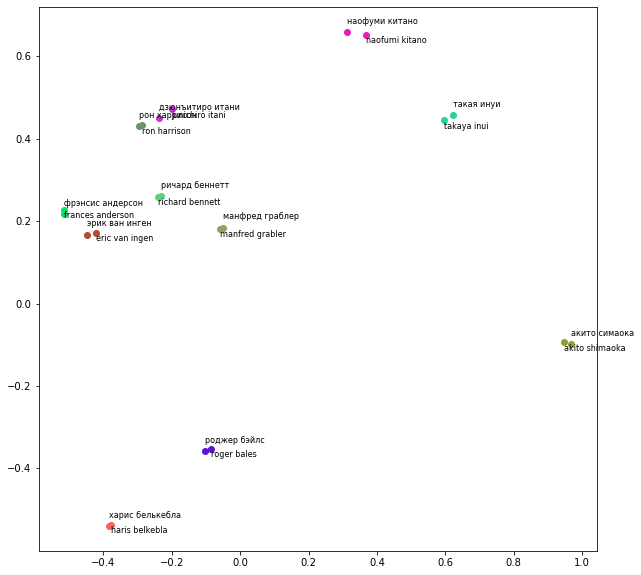

In [320]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))


inds = get_examples(df_test[500:])


for indx in inds:
    c=np.random.rand(3,)
    plt.scatter(principalComponents_left[indx,0], principalComponents_left[indx,1], alpha=1, color=c)
    plt.scatter(principalComponents_right[indx,0], principalComponents_right[indx,1], alpha=1, color=c)
    
for indx in inds:
    plt.text(principalComponents_left[indx,0], principalComponents_left[indx,1]-0.02, df_test['source'][indx], fontsize=8) 
    plt.text(principalComponents_right[indx,0], principalComponents_right[indx,1]+0.02, df_test['target'][indx], fontsize=8)   



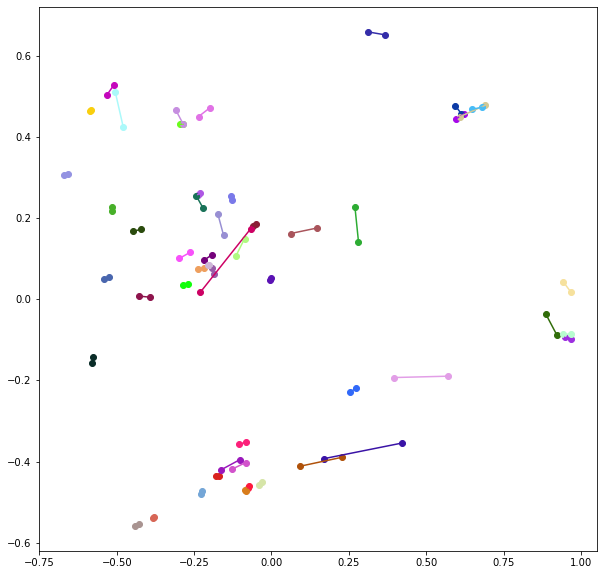

In [337]:
plt.figure(figsize=(10,10))


inds = get_examples(df_test[500:], 50)


for indx in inds:
    c=np.random.rand(3,)
    plt.scatter(principalComponents_left[indx,0], principalComponents_left[indx,1], alpha=1, color=c)
    plt.scatter(principalComponents_right[indx,0], principalComponents_right[indx,1], alpha=1, color=c)
    plt.plot([principalComponents_left[indx,0], principalComponents_right[indx,0]],[principalComponents_left[indx,1], principalComponents_right[indx,1]], color=c)
    
#for indx in inds:
    #plt.text(principalComponents_left[indx,0], principalComponents_left[indx,1]-0.02, df_test['source'][indx], fontsize=8) 
    #plt.text(principalComponents_right[indx,0], principalComponents_right[indx,1]+0.02, df_test['target'][indx], fontsize=8)   


Int64Index([2, 28, 34, 81, 93, 147, 158, 169, 177, 208, 267, 292, 293, 295], dtype='int64')

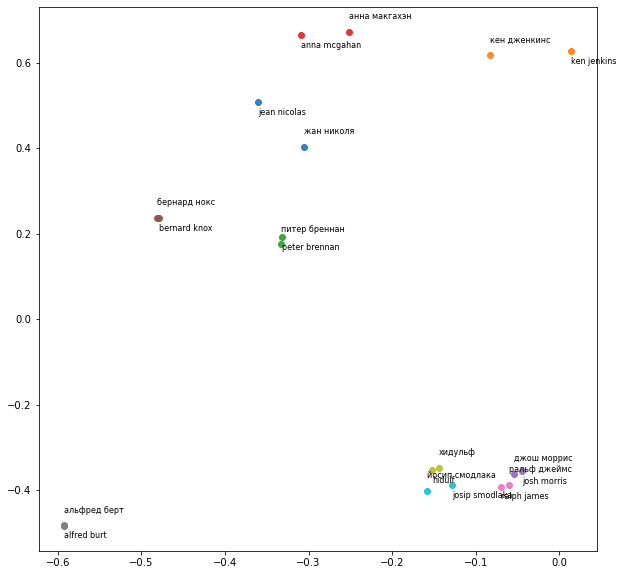

In [231]:
# old code, manual example

import matplotlib.pyplot as plt

mnist_classes = ['0', '1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.figure(figsize=(10,10))

inds = df_test[df_test['y']!=df_test['y_hat']].index


for i, indx in enumerate([0, 3, 4, 6, 15, 21, 22, 35, 41, 52]):
    plt.scatter(principalComponents_left[indx,0], principalComponents_left[indx,1], alpha=0.9, color=colors[i])
    plt.scatter(principalComponents_right[indx,0], principalComponents_right[indx,1], alpha=0.9, color=colors[i])

    
plt.plot()
    

for indx in [0, 3, 4, 6, 15, 21, 22, 35, 41, 52]:
    plt.text(principalComponents_left[indx,0], principalComponents_left[indx,1]-0.03, df_test['source'][indx], fontsize=8) 
    plt.text(principalComponents_right[indx,0], principalComponents_right[indx,1]+0.03, df_test['target'][indx], fontsize=8)   
    
    
inds